## Predict Ratings using Business Reviews

This notebook consists of codes that will :

1. Read a csv file containing business reviews.
2. Generate word vectors using Gensim Word2Vec.
3. Construct and fit a keras deep learning model to predict ratings.

# Import Libraries


In [ ]:
#Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
import re
import string

from multiprocessing import Queue

#Abstract Syntax Trees - used to convert dataframe review tokens that are imported as text back to lists.
import ast

#Used for timing modeling and other longer-running sections.
import time

#Used for testing classifiers
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

#Gensim
import gensim
from gensim.models import Word2Vec

#Pickle
import pickle

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

#Keras
import keras
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, GlobalMaxPool1D
from keras.preprocessing import text, sequence

from textblob import TextBlob, Word, Blobber
# to install textblob in your conda packages:
# 1. go to anaconda prompt
# 2. cd Anaconda3>Scripts>conda install -c conda-forge textblob

#nltk
import nltk
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
from nltk import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Set Data and Target variables


In [ ]:
reviews_df = pd.read_csv("/content/drive/My Drive/NLP-Colab Notebook/sf_wclothing_boutiques_review.csv")
pd.options.display.max_colwidth = 500

#Reviews need to convert to a list of strings.
reviews_df.head()
for i in range(1,6):
  reviews_df["review_ratings"] = reviews_df["review_ratings"].replace( str(i) + " star rating", str(i))
reviews_df

,Unnamed: 0,review_counts,boutique_names,number_reviews,url_address,reviews,review_dates,review_ratings
0,0,0,Kisha Studio Fashion Boutique,120,https://www.yelp.com/biz/kisha-studio-fashion-boutique-san-francisco-2?osq=Clothing+Boutiques,Oh my goodness im so in lovewith the dress that I received from kisha studio today. I ordered a black dress that I saw on Instagram on Tuesday the 21st of April it arrived at my mailbox in 4 days. How awesome is that. I really wanted this dress so I asked about it how would it fit because I'm a short chick and yeah that's my problem. But she insured me that it will be okay so I said yes please i want it.. I gave her my cc info thru direct message thru instatram and boom i hit a tracking n...,4/26/2020,5
1,1,1,Kisha Studio Fashion Boutique,120,https://www.yelp.com/biz/kisha-studio-fashion-boutique-san-francisco-2?osq=Clothing+Boutiques,"I love Kisha! I always find something I need and want there. Kisha is so helpful and awesome. She always gives great fashion tips, which I need!Price is right and stuff is super cute. Great customer service too. Shop local!",12/15/2019,5
2,2,2,Kisha Studio Fashion Boutique,120,https://www.yelp.com/biz/kisha-studio-fashion-boutique-san-francisco-2?osq=Clothing+Boutiques,This shop has the most adorable selection of clothes and they were having a 4th of July sale where everything was 15% off. They had quite a few prints that were appealing and prices were very reasonable. The owner is very friendly and sweet as well.,7/7/2017,5
3,3,3,Kisha Studio Fashion Boutique,120,https://www.yelp.com/biz/kisha-studio-fashion-boutique-san-francisco-2?osq=Clothing+Boutiques,"I've been shopping here for two years now, and I will definitely continue to shop here for unique and fashionable clothes. I've gotten compliments on everything I've worn here. I'm actually wearing a shirt I've gotten at Kisha right now!I've gotten to know Cindy, the owner, and she's the most lovely person you can ever meet. She always has a big smile when my roommates and I enter the shop, and she already knows exactly what our tastes in clothing are. Once we start browsing, she already...",7/20/2015,5
4,4,4,Kisha Studio Fashion Boutique,120,https://www.yelp.com/biz/kisha-studio-fashion-boutique-san-francisco-2?osq=Clothing+Boutiques,"LOVE LOVE LOVE Kisha Studio! Cindy is awesome and has the magic power to find you the perfect piece regardless of your needs. My friend who lives in LA even told me to bring her here on her next visit.Here's a very recent example. I went in over the weekend looking last minute for a dress to wear to a wedding. Cindy grabbed two maxi dresses for me to try on. Now I'm 5'3"" aka short and never wear maxi dresses. But both dresses fitted perfectly and looked so good on me that I seriously thought...",9/26/2017,5
...,...,...,...,...,...,...,...,...
12363,12363,84,Triple Aught Design,89,https://www.yelp.com/biz/triple-aught-design-san-francisco?osq=Clothing+Boutiques,"This place has moved to 660 22nd Street in the city. It's a great place with a 'refined' selection of gear - they don't just sell anything, but hand select what they feel are the best made camping and hiking pieces. Can be a little pricey, but where else are you going to get that weight-bearing grappling hook you need so badly?",4/26/2005,4
12364,12364,85,Triple Aught Design,89,https://www.yelp.com/biz/triple-aught-design-san-francisco?osq=Clothing+Boutiques,"This store is absurd. Always on the lookout for decent gear, I checked out the Hayes Valley store a couple of weeks ago. For the most part, the stuff is good quality and well thought-out, though it is ridiculously overpriced. My greatest objection, however, is the idea of trendy, Gucci-priced tactical gear, marketed to be worn by urban hipsters or weekend recreationists spending the afternoon at Point Reyes, undoubtedly convinced that they are super awesome because they are sporting the lat...",11/14/2011,1
12365,12365,86,Triple Aught Design,89,https://www.yelp.com

In [ ]:
#Prepare data to split:
class data_preparation:
    
    #def __init__(self):        
         
    def clean_review(self, reviews_df):
        """
        This function cleans a block of text by applying: text_cleaning and remove_stopwords.
        Input:text = the text to be cleaned.
        Output: the text stripped of punctuation and made lowercase, with no stopwords.
        """        
        for review in reviews_df["reviews"]:
            # u'\xa0' represents a non-breaking space in the text block that needs to be removed.
            review = review.replace(u'\xa0', u' ')

            #remove multiple fullstops and make a single fullstop
            review = re.sub('\.+', '. ', review)

            #remove multiple spaces and make a single space.
            review = re.sub(' +', ' ', review)

            #remove all tokens that are not alphabetic
            review = re.sub(r'\d+', '', review)

            #normalization
            review =  review.lower()

            #Define punctuations according to nltk corpus.
            punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*_~+.'''
            #remove punctuations, traverse the given string and if any punctuation marks occur replace it with null 
            for i in review: 
                if i in punctuations: 
                    review = review.replace(i, "") 

            tokens = word_tokenize(review)
            #remove stopwords
            stop_words = set(stopwords.words('english'))
            tokens = [token for token in tokens if not token in stop_words]
            #return the cleaned text in a sentence format.
            cleaned_review = ' '.join([''.join(token) for token in tokens])
            reviews_df_clean = reviews_df.replace(review, cleaned_review, inplace=False)

        return reviews_df_clean

    def split_data(self, reviews_df):
        #data = self.tokenized_reviews(reviews_df_clean.reviews)
        reviews_df_clean = self.clean_review(reviews_df)
        #data = self.tokenized_reviews(reviews_df_clean)
        #data = [self.tokenized_reviews(review) for review in reviews_df_clean.reviews]
        data = [nltk.word_tokenize(review) for review in reviews_df_clean.reviews]
        target = reviews_df_clean.review_ratings
        x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, stratify=target)
        
        train_counts = y_train.value_counts()
        test_counts = y_test.value_counts()
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,4))
        sns.barplot(x=train_counts.index,y=train_counts.values, ax=ax1)
        sns.barplot(x=test_counts.index,y=test_counts.values, ax=ax2)
        ax1.set_title('Train Data: Num Reviews by Star Rating');
        ax2.set_title('Test Data: Num Reviews by Star Rating');
        return x_train, x_test, y_train, y_test

    def generate_word_vectors():
        dim = 20 #Dimensionality of word vectors
        model = Word2Vec(x_train,size=dim,window=5,min_count=1,workers=4)
        model.train(data,total_examples=model.corpus_count,epochs=10) 
        #Save embedded word vector space
        wv = model.wv
        print(len(wv.vocab),"unique words in the dataset.")


((11131,), (1237,))

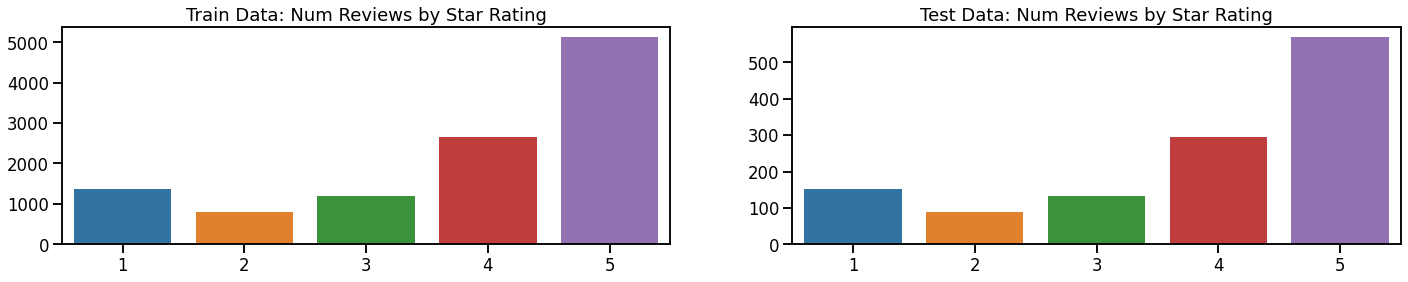

In [ ]:
# Invoke methods one by one
obj = data_preparation()
x_train, x_test, y_train, y_test = obj.split_data(reviews_df)
y_train.shape, y_test.shape


In [ ]:
#generate_word_vectors:
dim = 10 #Dimensionality of word vectors
model = Word2Vec(x_train,min_count=2,size=dim)
#Save embedded word vector space
wv = model.wv
print(len(wv.vocab),"unique words in the dataset.")

17499 unique words in the dataset.


In [ ]:
 model.train(x_train,total_examples=model.corpus_count,epochs=100) 

(100057983, 140123800)

# Predict Ratings using Keras LSTM Network Model

In [ ]:
#Creating Word Embeddings using Embedding Vectorizer class
class Tokenizer(object):
    """
    This class is used to fit text and transfer text to sequences for use in a Keras NN Model.
    The class has both fit and transform functions to be used in an sklearn Pipeline.
    num_words = max number of words to keep.
    maxlen  = max length of all sequences.
    """
    def __init__(self, num_words=20000, maxlen=100):
        self.tokenizer = text.Tokenizer(num_words=num_words)
        self.maxlen = maxlen
        
    def fit(self, x, y):
        self.tokenizer.fit_on_texts(x)
        return self
        
    def transform(self, x):
        return sequence.pad_sequences(self.tokenizer.texts_to_sequences(x), maxlen=self.maxlen)
    
class Model(object):
    """
    This class is used to fit and transform a keras model for use in an sklearn Pipeline.
    """
    def __init__(self, model, epochs=3, batch_size=32, validation_split=0.1):
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        
    def set_params(self, epochs=3, batch_size=32, validation_split=0.1):
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        return self
    
    def fit(self, x, y):
        y_dummies = pd.get_dummies(y).values
        self.labels = np.array(pd.get_dummies(y).columns)
        self.model.fit(x, y_dummies, epochs=self.epochs, batch_size=self.batch_size, validation_split=self.validation_split)
        return self
    
    def transform(self, x):
        return x
    
    def predict(self, x):
        y_pred = self.model.predict(x)
        return [self.labels[idx] for idx in y_pred.argmax(axis=1)]
    
    def summary(self):
        self.model.summary()
        

In [ ]:
def get_model():
  embedding_size = 128
  input_ = Input(shape=(100,))
  x = Embedding(20000, embedding_size)(input_)
  x = LSTM(25, return_sequences=True)(x)
  x = GlobalMaxPool1D()(x)
  x = Dropout(0.5)(x)
  x = Dense(50, activation='relu')(x)
  x = Dropout(0.5)(x)
  # There are 5 different possible rating levels, therefore using 5 neurons in output layer
  x = Dense(5, activation='softmax')(x)

  keras_model = Model(inputs=input_, outputs=x)

  keras_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  #keras_model.summary()
  return keras_model

In [ ]:
keras_model = get_model()
param_grid_km  = [{'Keras LSTM Model__epochs': [2],
                   'Keras LSTM Model__batch_size': [32] }]

km  = Pipeline([("Keras Tokenizer", Tokenizer(num_words=20000, maxlen=100)),
                 ("Keras LSTM Model", Model(keras_model, epochs=10, batch_size=32, validation_split=0.1))])

In [ ]:
km.fit(x_train,y_train)

Epoch 1/10
314/314 [==============================] - 23s 73ms/step - loss: 1.3295 - accuracy: 0.4385 - val_loss: 1.0857 - val_accuracy: 0.5180
Epoch 2/10
314/314 [==============================] - 22s 70ms/step - loss: 1.0666 - accuracy: 0.5441 - val_loss: 1.0029 - val_accuracy: 0.5790
Epoch 3/10
314/314 [==============================] - 23s 74ms/step - loss: 0.9262 - accuracy: 0.6043 - val_loss: 1.0118 - val_accuracy: 0.5925
Epoch 4/10
314/314 [==============================] - 23s 74ms/step - loss: 0.8121 - accuracy: 0.6561 - val_loss: 1.1319 - val_accuracy: 0.5880
Epoch 5/10
314/314 [==============================] - 23s 74ms/step - loss: 0.7392 - accuracy: 0.7002 - val_loss: 1.2126 - val_accuracy: 0.5709
Epoch 6/10
314/314 [==============================] - 23s 74ms/step - loss: 0.6569 - accuracy: 0.7409 - val_loss: 1.5215 - val_accuracy: 0.5619
Epoch 7/10
314/314 [==============================] - 24s 78ms/step - loss: 0.6045 - accuracy: 0.7611 - val_loss: 1.4669 - val_accuracy:

Pipeline(memory=None,
         steps=[('Keras Tokenizer',
                 <__main__.KerasTokenizer object at 0x7f4d93674d68>),
                ('Keras LSTM Model',
                 <__main__.KerasModel object at 0x7f4d93674cc0>)],
         verbose=False)

In [ ]:
result = {}    
y_pred_train = km.predict(x_train)
y_pred_test  = km.predict(x_test)

result['accuracy train']  = round(accuracy_score(y_train,y_pred_train),4)
result['accuracy test']   = round(accuracy_score(y_test,y_pred_test),4)
result

{'accuracy test': 0.5627, 'accuracy train': 0.866}

# Confusion Matrix


In [ ]:
def get_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          custom_stat_value=None,
                          custom_stat_text=''):
    '''
    This function will make a plot of Confusion Matrix using Seaborn heatmap visualization.
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
    '''


    #generate text inside each square
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    #generate summary statistics & text
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
        stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text += "\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                precision,recall,f1_score)
    else:
        stats_text = ""
        
    if custom_stat_value:
        stats_text += "\n{}={:0.3f}".format(custom_stat_text,custom_stat_value)


    #set figure parameters
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    #heatmap visualization 
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

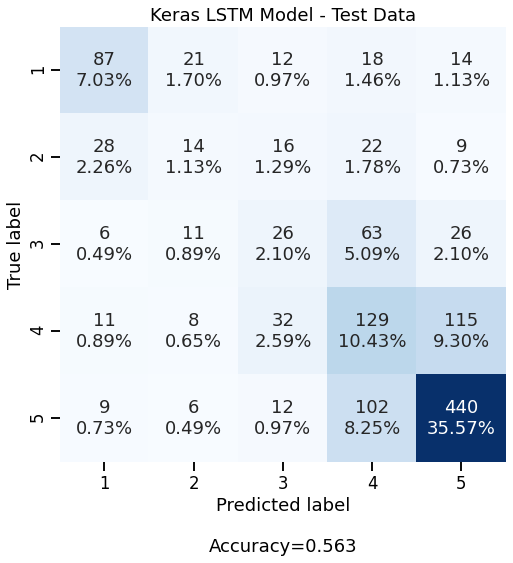

In [ ]:
y_pred_test = km.predict(x_test)
cf = confusion_matrix(y_test, y_pred_test)

make_confusion_matrix(cf, 
                      categories=[1,2,3,4,5], 
                      cbar=False, 
                      figsize=(8,8), 
                      title="Keras LSTM Model - Test Data")
